In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [112]:
df = pd.read_csv("fatal-police-shootings-data.csv")

In [113]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


In [114]:
# first name and last name
df['first_name'] = df['name'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
df['last_name'] = df['name'].apply(lambda x: x.split()[-1] if isinstance(x, str) else None)

In [115]:
# add month and year
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))
df['month'] = df['date'].apply(lambda x: x.month)
df['year'] = df['date'].apply(lambda x: x.year)

In [116]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,first_name,last_name,month,year
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,...,attack,Not fleeing,False,-123.122,47.247,True,Tim,Elliot,1,2015
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,...,attack,Not fleeing,False,-122.892,45.487,True,Lewis,Lembke,1,2015
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,...,other,Not fleeing,False,-97.281,37.695,True,John,Quintero,1,2015
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,...,attack,Not fleeing,False,-122.422,37.763,True,Matthew,Hoffman,1,2015
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,...,attack,Not fleeing,False,-104.692,40.384,True,Michael,Rodriguez,1,2015


C:\Users\fongc\AppData\Local\Temp\ipykernel_21540\2757988185.py:64: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


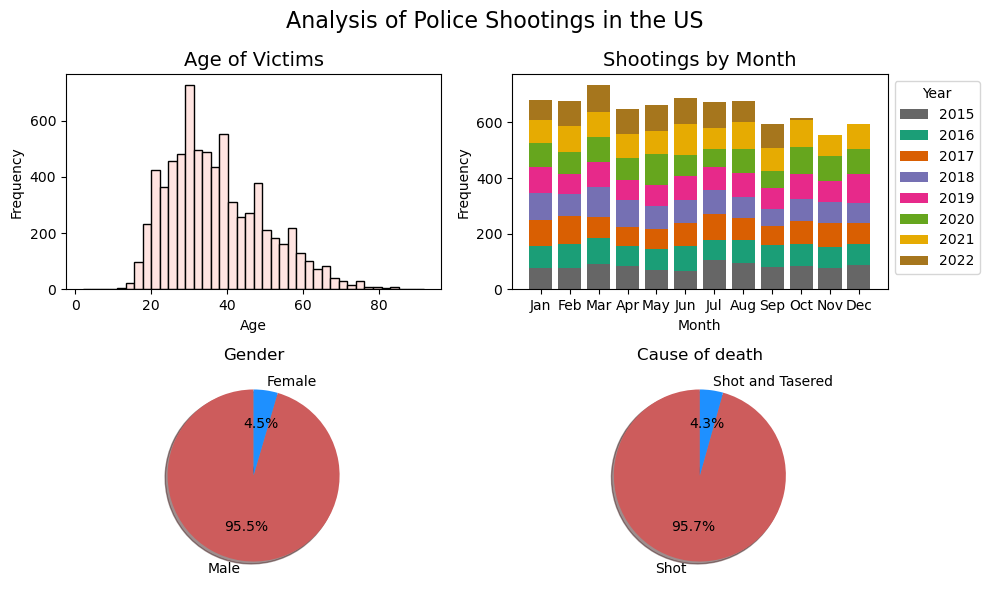

In [179]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Analysis of Police Shootings in the US", fontsize = 16)

# histogram plot
ax1.hist(
    x = df['age'],
    bins = 40,
    color = 'mistyrose',
    ec = 'black'
)
ax1.set_title("Age of Victims", fontsize = 14)
ax1.set_xlabel("Age")
ax1.set_ylabel("Frequency")

# stacked bar plot of dates
height_previous = np.zeros(12)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for year in sorted(df['year'].unique()):
    height_year = df[df['year'] == year]['month'].value_counts().sort_index().reindex(range(1, 13), fill_value=0)

    # plot bar chart
    ax2.bar(
        x = months,
        height = height_year,
        label = year,
        bottom = height_previous,
        color = plt.get_cmap("Dark2")(year % 8)
    )
    height_previous += height_year
ax2.set_title("Shootings by Month", fontsize = 14)
ax2.set_xlabel("Month")
ax2.set_ylabel("Frequency")
ax2.legend(
    title = "Year",
    loc = 'upper left',
    bbox_to_anchor = (1, 1)
)

# line graph of shootings by month
gender = df['gender'].value_counts()
ax3.pie(
    x = gender,
    labels = [ "Male", "Female" ],
    autopct = "%1.1f%%",
    shadow = True,
    startangle = 90,
    colors = [ "indianred", "dodgerblue" ]
)
ax3.set_title("Gender")

# pie chart of manner of death
manner_of_death = df['manner_of_death'].value_counts()
ax4.pie(
    x = manner_of_death,
    labels = [ "Shot", "Shot and Tasered" ],
    autopct = "%1.1f%%",
    shadow = True,
    startangle = 90,
    colors = [ "indianred", "dodgerblue" ]
)
ax4.set_title("Cause of death")

fig.tight_layout()
fig.show()